# Lab 5: Model Selection and Regularization

In  this session, we will use the already seen datasets to illustrate important techniques like validation and regularization. First, we use the student "exams" dataset to understand the need of test data in addition to the training data.  

Then, we will illustrate the under-fitting and over-fitting phenomenas on randomly generated data. After that, we will select a model that fits the best our validation data.

Finally, we will implement regularization technique on the "Microchip" testing dataset. Thus, we can understand how this technique helps to prevent over-fitting. 

<h2>Preparation</h2>

We'll need the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import fmin_bfgs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics.regression import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
%matplotlib notebook

### Part 1: Train and Test data: Student "exams" dataset

In this part, we will train a logistic classifier on the training data of student "exams" dataset. Then, we will predict the student admission of the test data and compare the accuracy of the classifier on the training and test data.

**Question 1: **  
The *"exams_train_data.txt"* file contains 3 columns that represent the exam 1, exam 2 scores and the results of 100 students (0: Not admitted, 1: Admitted). 
- Load train data from "exams_train_data.txt" file in "students_results_train" variable and check its size. (use [loadtxt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html) function from numpy library)
- Extract the number of students, the features and the output.
- Implement the "Poly_Features" function that concatenates to data array the different possible powers (below deg) and interaction terms of feature vectors f1 and f2 as shown below:$$data=[1,~f_1,~ f_2,~ f_1^2,~ f_1\times f_2,~ f_2^2,~ \dots,~ f_1^{deg},~ f_1^{deg-1}\times f_2,~\dots,~ f_2^{deg}]$$

In [2]:
#load training data
# Type your code here
students_results_train = np.loadtxt("exams_train_data.txt")

# you could verify the size of the data using shape() function on numpy array house_data
print("The training data contains {0} student results. There are {1} columns for each exam score and 1 column for admission".format(students_results_train.shape[0],students_results_train.shape[1]-1))

# # Type your code here
m_train = students_results_train.shape[0]           # number of student
x_1_train = students_results_train[:,0, np.newaxis] # we add np.newaxis in the indexing to obtain an array 
x_2_train = students_results_train[:,1, np.newaxis] # with shape (m,1) instead of (m,)
y_train = students_results_train[:,2, np.newaxis]   # the student admission result vector

students_results_train
y_train
x_2_train

The training data contains 100 student results. There are 2 columns for each exam score and 1 column for admission


array([[15.6 ],
       [ 8.78],
       [14.58],
       [17.26],
       [15.07],
       [11.26],
       [19.3 ],
       [ 9.31],
       [17.48],
       [ 8.71],
       [ 7.65],
       [ 6.12],
       [15.3 ],
       [19.54],
       [15.21],
       [17.84],
       [10.55],
       [ 9.34],
       [18.59],
       [ 9.52],
       [ 8.57],
       [13.16],
       [ 9.77],
       [ 8.84],
       [13.79],
       [13.99],
       [ 8.96],
       [ 7.76],
       [10.05],
       [13.  ],
       [14.56],
       [11.41],
       [12.63],
       [13.89],
       [14.23],
       [10.44],
       [19.77],
       [16.18],
       [ 8.31],
       [15.05],
       [11.26],
       [ 9.37],
       [13.11],
       [ 8.12],
       [ 9.16],
       [10.41],
       [14.09],
       [17.35],
       [19.35],
       [17.74],
       [14.83],
       [12.2 ],
       [ 8.68],
       [12.08],
       [ 9.96],
       [11.96],
       [13.77],
       [19.12],
       [13.96],
       [15.69],
       [17.15],
       [ 9.4 ],
       [

In [3]:
# Integrate interaction terms (x_1^i*x_2^j where i+j<=degree)
def Poly_Features(data,f1,f2,deg,ax=1):
    # f1 et f2 are features
    # Type your code here
    for i in range (deg):
        for j in range(deg):
            if (i+j <= deg) and i!=j:
                y = f1**i*f2**j
                data=np.concatenate((data,y),axis=ax)
                print(i,j)
    #print(data)
    return data

**Question 2: ** 
- Use the implemented function "Poly_Features" to generate the array of features X_train.
- Determine the number of features n.

In [4]:
# add polynomial features to the array data X
degree=2  # degree of polynomial feature
X_train=np.ones((m_train,1))   # initialize X array
# Type your code here
X_train = Poly_Features(X_train,x_1_train,x_2_train,degree,ax=1)  
n = np.array(X_train).shape[1]                        # number of features
print("The number of features is: ",n)
#X_train

0 1
1 0
The number of features is:  3


**Question 3: **  
- Create a sigmoid function that returns $sigmoid(z)=\frac{1}{1+e^{-z}}$  
**Hint:** For a vectorized implementation:
- Use [<code>numpy.ones</code>](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ones.html) to have a numerator with the same shape of z
- Use [<code>numpy.exp</code>](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)

In [5]:
def sigmoid(z):
    # Type your code here
    sig = 1 /(np.ones(z.shape) + np.exp(-z))
    return sig

**Question 4: **
- Create your logistic regression predict function
$$yhat=sigmoid(\theta^\top x)=\frac{1}{1+e^{-\theta^\top x}}$$
**Hint:** Use the sigmoid function  
This new hypothesis formulas will ensure: $0\leq yhat_i\leq 1$ 

In [6]:
# Create predict function
def predict(x,theta):
    yhat = sigmoid(np.dot(x,theta)) # /!\ matrix multiplication
    return yhat

**Question 5:** 
- Store in the variable m the number of samples.
- Define the criterion or cost function that returns the NLL (Negative Log Likelihood Error):  
**Negative Log Likelihood Error (NLL)**: $$cost=J(\theta)=\frac{-1}{m}\sum_{i=1}^{m}\left [y\times log(yhat)+(1-y)\times log(1-yhat)\right ]$$
**Hint:** For a vectorized implementation:
- Use [<code>numpy.sum</code>](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.sum.html) and [<code>numpy.log</code>](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.log.html)

In [7]:
def NLL_cost(yhat, y):
    # Type your code here

    m = y.shape[0] # nf of samples
    to_sum = y*np.log(yhat)+(1-y)*np.log(1-yhat)
    J = (-1/m)*(np.sum(to_sum))
    
    return J

**Question 6:** 
The gradient vector of the logistic cost function is calculated as following: $$\nabla J(\theta) = \begin{bmatrix}\frac{\partial J(\theta)}{\partial \theta_0}
\\ \frac{\partial J(\theta)}{\partial \theta_1}
\\ \vdots
\\ \frac{\partial J(\theta)}{\partial \theta_{n-1}}
\end{bmatrix}$$ 
where: $\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}{(yhat_i - y_i)~x_{ij}} ~~for~ j=0\dots n-1$
- Implement the "grad_cost_func" function that evaluates the gradient of logistic cost function.  
**Hint:** You can use the vectorized form: $\nabla J(\theta) =\frac{1}{m} x^T(yhat-y)$

In [8]:
def grad_cost_func(theta, x, y):
    # Type your code here
    m = y.shape[0]
    g = 1/m*np.dot(np.transpose(x), predict(x,theta)-y)    
    return g   

**Question 7: **
- Call "fmin_bfgs" function to calculate the optimal theta. This function take as parameters: the name of cost function ("NLL_cost_fn"), the name of gradient cost function ("grad_cost_fn") and the initial theta ("theta0").
- Print the optimal theta.

In [9]:
def NLL_cost_fn(theta):
    J=NLL_cost(predict(X_train,theta[:,np.newaxis]), y_train)
    return J

In [10]:
def grad_cost_fn(theta):
    g=grad_cost_func(theta[:,np.newaxis], X_train, y_train)
    g.shape=(g.shape[0],)
    return g  

In [11]:
# calculate optimal theta
theta0=np.zeros((n,))
# Type your code here
#J = NLL_cost_fn(theta0)
#g = grad_cost_fn(theta0)
#theta_opt = fmin_bfgs(J,g,theta0)
theta_opt = fmin_bfgs(NLL_cost_fn,theta0,grad_cost_fn)
print("The optimal value of theta that minimize cost function is: ",)

Optimization terminated successfully.
         Current function value: 0.203398
         Iterations: 18
         Function evaluations: 24
         Gradient evaluations: 24
The optimal value of theta that minimize cost function is: 


**Question 8: **
- Predict "y_pred_train" the admission result of each student on train data.
- Calculate the training accuracy (number of good prediction/number of all student) on the training data.

In [12]:
# calculate prediction and train accuracy
# Type your code here

y_pred_train = predict(X_train, theta_opt) #we have a probability : values from 0 to 1

min_y_pred_train = min(y_pred_train)
max_y_pred_train = max(y_pred_train)

# fail for values < 0.5, pass for others
y_pred_train_bin = [0 if x <0.5 else 1 for x in y_pred_train] 

# Count numbers of good predictions
good_predictions = [True if y_pred_train_bin[i] == y_train[i] else False for i in range(y_train.shape[0])] #true if the prediction is right
nb_good_predictions = sum(good_predictions)

train_accuracy =  nb_good_predictions/y_train.shape[0]
# print("The accuracy on the training data is:", train_accuracy,"%")


In [13]:
len(y_train)
y_train.shape[0]

100

Let's visualize the decision boundaries on the train data

0 1
1 0


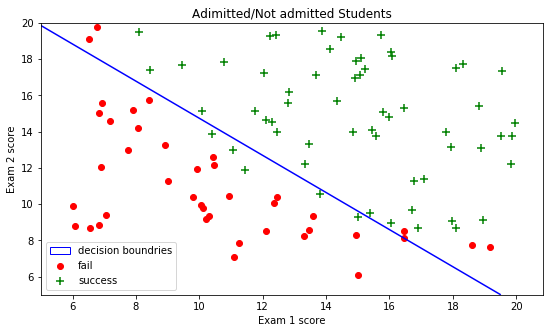

In [14]:
# calculate the mesh grid for contour plot
u1=np.linspace(5,20,100)
u2=np.linspace(5,20,100)
u1, u2 = np.meshgrid(u1, u2)

X3=np.ones((*u1.shape,1))

X3=Poly_Features(X3,u1[...,np.newaxis],u2[...,np.newaxis],degree,-1)

Z=np.dot(X3,theta_opt)

# plot descision boundries
plt.figure("Admission decision boundries",figsize=(9,5))
fail=plt.scatter(x_1_train[y_train==0], x_2_train[y_train==0],  color='red',label='fail')
success=plt.scatter(x_1_train[y_train==1], x_2_train[y_train==1],  color='green',marker='+',s=80,label='success')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Adimitted/Not admitted Students')
ctr = plt.contour(u1, u2, Z,0,colors="blue")
extra = Rectangle((0, 0), 3, 4, fc="w", fill=False, edgecolor="b", linewidth=1)
plt.legend([extra,fail,success], ("decision boundries","fail","success"),loc='best')

**Question 9: **
- Load test data from "exams_test_data.txt" file in "students_results_test" variable and check its size. (use [loadtxt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html) function from numpy library).
- Calculate the test accuracy (number of good prediction/number of all student) on the test data and compare it with the train accuracy. Interpret the difference.

In [15]:
# Type your code here
students_results_test = np.loadtxt('exams_test_data.txt',delimiter='\t')  # ** your code here** 

# Type your code here
m_test = students_results_test.shape[0]                # number of student in test data
x_1_test = students_results_test[:,0][:,np.newaxis]    # we add np.newaxis in the indexing to obtain an array 
x_2_test = students_results_test[:,1][:,np.newaxis]    # with shape (m,1) instead of (m,)
y_test = students_results_test[:,2][:,np.newaxis]    # we add np.newaxis in the indexing to obtain an array with shape (100,1) instead of (100,)


# add polynomial features to the array data X_test
# Type your code here
X_test = np.ones((m_test,1))   # initialize X array
X_test = Poly_Features(X_test, x_1_test, x_2_test, degree, 1)



# calculate prediction and accuracy on test data
# Type your code here
y_test_pred = predict(X_test, theta_opt)
test_accuracy = sum(y_test_pred[:,np.newaxis]==y_test)/len(y_test) 
print("The accuracy on the test data is:", test_accuracy,"%")

0 1
1 0
The accuracy on the test data is: [0.] %


Let's visualize the decision boundaries on the train and test data

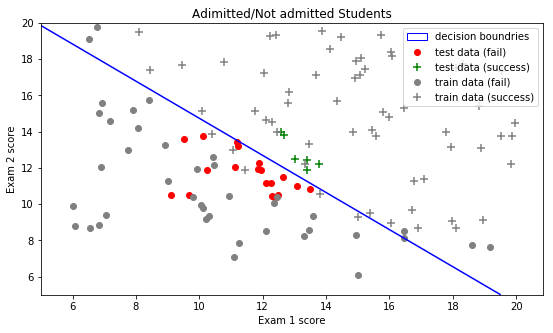

In [16]:
# plot descision boundries and test data
plt.figure("decision boundries and test data",figsize=(9,5))
fail=plt.scatter(x_1_test[y_test==0], x_2_test[y_test==0],  color='red')
success=plt.scatter(x_1_test[y_test==1], x_2_test[y_test==1],  color='green',marker='+',s=80)
fail_train=plt.scatter(x_1_train[y_train==0], x_2_train[y_train==0],  color='gray')
success_train=plt.scatter(x_1_train[y_train==1], x_2_train[y_train==1],  color='gray',marker='+',s=80)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Adimitted/Not admitted Students')
ctr = plt.contour(u1, u2, Z,0,colors="blue")
plt.legend([extra,fail,success,fail_train,success_train], ("decision boundries","test data (fail)","test data (success)","train data (fail)","train data (success)"),loc='best')

### Part 2: Underfitting and Overfitting

In this part we will study the effect of the number of features and the model complexity on the training phase and we will illustrate the underfitting and overfitting phenomena. We will use randomly generated data for a regression problem and we will try to use several models with different number of features (different polynomial features degrees). Then, we will see how well the model fits the training and the test data.

**Question 1: **
- Split the data ("x" and "y" vector) to training and test data with size "m_train" and "m_test" respectively. The original data is sorted. Therefore, you should choose the training and the test sets randomly to ensure that the two sets cover the possible values space in a best manner.  
**Hint:** You can use [random permutation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) function to generate a random permutation of "m" indices for "x" and "y" vectors. Then, you can select the first "m_train" indices to index train data from "x" and "y". You can use the rest of indices to index the test data.

In [17]:
# generate random data
np.random.seed(0)
m = 15
x = np.linspace(0,10,m) + np.random.randn(m)/5
y = np.sin(x)+x/6 + np.random.randn(m)/10


# calculate the size of training and test sets
train_ratio = 0.75
m_train = int(round(train_ratio*m)) 
m_test = m-m_train
print("the size of training set is:",m_train,"\nthe size of test set is:",m_test)

# split the data to training and test sets
np.random.seed(9599)
# Type your code here



rand_perm = np.random.permutation(m_train)
X_train= x[rand_perm]
y_train= y[rand_perm]
X_test=  x[m_train:m] 
y_test= y[m_train:m]

the size of training set is: 11 
the size of test set is: 4


Let's visualize training and test set

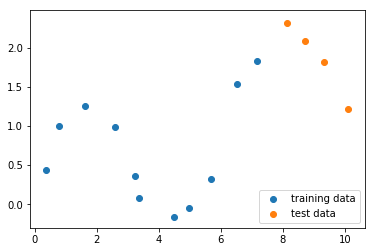

In [18]:
# visualize training and test set
plt.figure("training and test set")
plt.scatter(X_train, y_train, label='training data')
plt.scatter(X_test, y_test, label='test data')
plt.legend(loc="lower right")

**Question 2: **
- Use [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class and [PolynomialFeatures.fit_transform](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.fit_transform) functions from numpy library to generate polynomial features of degree "i". This will generate automatically the features instead of adding them by hand as in the previous example with the implemented function "Poly_Features".

In [19]:
# train several polynomial models
regr = LinearRegression()
deg=[1,3,6,9,11]
Poly_predict=np.zeros((len(deg),200))
for i in range(len(deg)):
    # Type your code here
    poly = PolynomialFeatures(i)
    new_X = poly.fit_transform(X_train[:,np.newaxis], y_train)
    regr.fit(new_X, y_train[:,np.newaxis])
    u = np.linspace(0,11.5,200)   # 
    new_U = poly.fit_transform(u[:,np.newaxis])
    Poly_predict[i,:]=regr.predict(new_U).transpose()

Let's visualize different polynomial models

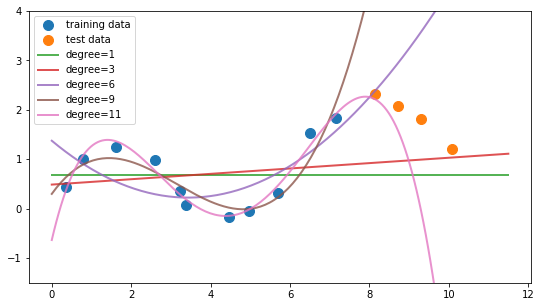

In [20]:
# visualize different polynomial models
plt.figure("different polynomial models",figsize=(9,5))
plt.plot(X_train, y_train, 'o', label='training data', markersize=10)
plt.plot(X_test, y_test, 'o', label='test data', markersize=10)
for i,degree in enumerate(deg):
    plt.plot(u, Poly_predict[i], alpha=0.8, lw=2, label='degree={}'.format(degree))
plt.ylim(-1.5,4)
plt.legend(loc="best")

### Model Selection
In this part, we will train several polynomial models. Then, we will assess their performance on the training and the test sets. Hence, we will choose  the model with best performance in both training and test set. However, the calculated performance on test data won't be a good estimation of the performance of our model in general case. In fact, our model order (polynomial degree) is fitted to the test data. Thus, it tends to perform better on test data than on a new data. Therefore, we introduce the validation data used for tuning model meta-parameters (polynomial degree, classification threshold...). Then, we will use the test data to estimate the performance of our model in general case.  

**Question 3: **
- Split the original data ("x" and "y" vector) to training, validation and test data with size "m_train", "m_val" and "m_test" respectively.  
**Hint:** You can use [random permutation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) function to generate a random permutation of "m" indices for "x" and "y" vectors. Then, you can select the first "m_train" indices to index train data from "x" and "y". Then, you can act similarly for validation and test sets.

In [21]:
# calculate the size of training, validation and test sets
train_ratio = 0.6
val_ratio = 0.2
m_train = int(round(train_ratio*m)) 
m_val = int(round(val_ratio*m)) 
m_test = m-m_train-m_val
print("the size of training set is:",m_train,"\nthe size of validation set is:",m_val,"\nthe size of test set is:",m_test)

the size of training set is: 9 
the size of validation set is: 3 
the size of test set is: 3


In [22]:
# split data to training, validation and test sets
np.random.seed(5190969)
# Type your code here
rand_perm = np.random.permutation(m_train)
X_train= x[rand_perm]
y_train= y[rand_perm]
X_val= x[m_train:m_train+m_val]
y_val= y[m_train:m_train+m_val]
X_test= x[m_train+m_val:m]
y_test= y[m_train+m_val:m]

Let's visualize training, validation and test sets

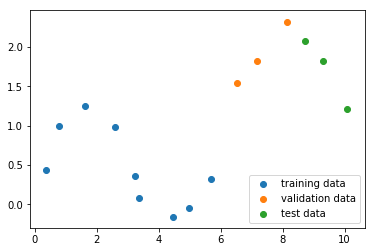

In [23]:
# visualize training, validation and test sets
plt.figure("training, validation and test sets")
plt.scatter(X_train, y_train, label='training data')
plt.scatter(X_val, y_val, label='validation data')
plt.scatter(X_test, y_test, label='test data')
plt.legend(loc="lower right")

**Question 4: **
- Calculate "train_error" and "val_error" mean squared error on training and validation set for each polynomial model with degree "i" (for loop counter).  
**Hint:** You can use [mean_squared_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function from sklearn library to evaluate the mean squared error between original "y" and "y_predicted".

In [24]:
# train and assess several polynomial models
train_error = np.zeros((deg[-1]+1,)) 
val_error = np.zeros((deg[-1]+1,))

for i in range(deg[-1]+1):
    poly = PolynomialFeatures(i)
    new_X_train= poly.fit_transform(X_train[:,np.newaxis])
    new_X_val = poly.fit_transform(X_val[:,np.newaxis])
    regr.fit(new_X_train, y_train[:,np.newaxis])

    # Type your code here
    y_train_predicted = regr.predict(new_X_train)
    y_val_predicted = regr.predict(new_X_val)
    train_error[i] = mean_squared_error(y_train, y_train_predicted)
    val_error[i] = mean_squared_error(y_val, y_val_predicted)
    print("degree {} polynomial has a train error: {:.5f} and validation error: {:.4f}".format(i,train_error[i],val_error[i]))

degree 0 polynomial has a train error: 0.22341 and validation error: 2.1387
degree 1 polynomial has a train error: 0.12637 and validation error: 4.9799
degree 2 polynomial has a train error: 0.12485 and validation error: 6.1284
degree 3 polynomial has a train error: 0.01091 and validation error: 19.6459
degree 4 polynomial has a train error: 0.00798 and validation error: 1.7618
degree 5 polynomial has a train error: 0.00490 and validation error: 147.8388
degree 6 polynomial has a train error: 0.00434 and validation error: 1324.7999
degree 7 polynomial has a train error: 0.00105 and validation error: 43883.7194
degree 8 polynomial has a train error: 0.00000 and validation error: 17261974.2222
degree 9 polynomial has a train error: 0.00000 and validation error: 69156192.7869
degree 10 polynomial has a train error: 0.00000 and validation error: 265257491.7825
degree 11 polynomial has a train error: 0.00000 and validation error: 770832074.1866


Let's visualize error of each polynomial model

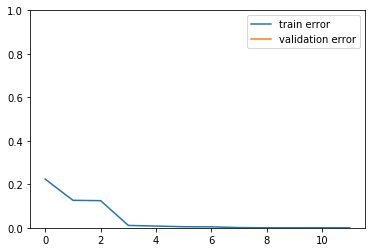

In [25]:
# visualize error of each polynomial model
plt.figure("train and validation error of each polynomial model")  
plt.plot(range(deg[-1]+1),train_error[:deg[-1]+1],label="train error")
plt.plot(range(deg[-1]+1),val_error[:deg[-1]+1],label="validation error")
plt.ylim(0,1)
plt.legend(loc="best")

**Question 5: **
- From the train and validation error graph and values, select the polynomial degree "best_poly_deg" that fit the best our data. Then, compare the training, validation and test error of this polynomial model. What do you notice?

In [26]:
# Type your code here
best_poly_deg = 5
poly = PolynomialFeatures(best_poly_deg)
new_X_train= poly.fit_transform(X_train[:,np.newaxis])
new_X_test = poly.fit_transform(X_test[:,np.newaxis])
regr.fit(new_X_train, y_train[:,np.newaxis])
# Type your code here
y_test_predicted = regr.predict(new_X_test)
test_error = mean_squared_error(y_test, y_test_predicted)
print("train error =",train_error[best_poly_deg],"\nvalidation error =",val_error[best_poly_deg],"\ntest error =",test_error)

train error = 0.004904775165541141 
validation error = 147.83878652217575 
test error = 7824.765555615987


### Part 3: Regularization

In this section, we will split the "Microchip" dataset into training and test sets. We will train a polynomial logistic classifier with and without regularization. Then, we will compare train and test accuracy in the two cases.  

The regularization helps to avoid the problem of overfitting by reducing or even making null $\theta_j's$ of non significant features. The idea is to include the sum of $\theta_j's$ in cost function in order to reduce them and remove useless features in our models.

The regularized cost function is equal to: $$J_{Reg}(\theta)= J(\theta)+\frac{\lambda}{2m}\times\sum_{j=1}^{n-1} \theta_j^2$$

The gradient of regularized cost function is equal to: 

$$\nabla J_{Reg}(\theta) = \begin{bmatrix}\frac{\partial J(\theta)}{\partial \theta_0}
\\ \frac{\partial J(\theta)}{\partial \theta_1}
\\ \vdots
\\ \frac{\partial J(\theta)}{\partial \theta_{n-1}}
\end{bmatrix}+\frac{\lambda}{m} \begin{bmatrix}0
\\ \theta_1
\\ \vdots
\\ \theta_{n-1}
\end{bmatrix}$$ 
where: $ \left\{\begin{matrix}
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}{(h_\theta(x_i) - y)~x_j} ~~for~ j=0\dots n-1 
\\ h_\theta(x_i)=sigmoid(\theta^\top x_i)=\frac{1}{1+e^{-\theta^\top x_i}}
\end{matrix}\right.$

**Question 1: **
- Load data from "microchip.txt" file (use [loadtxt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html) function from numpy library).
- Split "X" and "Y" data into train, validation and test sets with a size of 60%, 20% and 20% respectively.  
**Hint: ** You can use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from sklearn library (use the parameter random_state=799) instead of generating random permutation by hand.
- Extract the train features and use the implemented function "Poly_Features" to generate the array of train features X.
- Determine the number of features n.

In [27]:
# load and extract data
# Type your code here
degree=6    
microchip_data = np.loadtxt('microchip.txt', delimiter=',')   

m = microchip_data.shape[0]                               # number of mocrochips
x_1 = microchip_data[:,0][:,np.newaxis]                               # we add np.newaxis in the indexing to obtain an array 
x_2 = microchip_data[:,1][:,np.newaxis]                               # with shape (m,1) instead of (m,)
Y = microchip_data[:,2][:,np.newaxis]  # we add np.newaxis in the indexing to obtain an array with shape (m,1) instead of (m,)

X = np.ones((m,1))    # initialize X array
X = Poly_Features(X, x_1, x_2, degree, 1)  
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.4, random_state=799) 

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=799)
n = X.shape[1]

0 1
0 2
0 3
0 4
0 5
1 0
1 2
1 3
1 4
1 5
2 0
2 1
2 3
2 4
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1


In [28]:
# add polynomial features to the train data
degree=6    # degree of polynomial features
# Type your code here
x_1_train = 
x_2_train = 
Y=

# Type your code here
X =    # initialize X array
X = 
n = 

SyntaxError: invalid syntax (<ipython-input-28-5217a5a3b561>, line 4)

**Question 2: **  
- Create a sigmoid function that returns $sigmoid(z)=\frac{1}{1+e^{-z}}$  
**Hint:** For a vectorized implementation:
- Use [<code>numpy.ones</code>](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ones.html) to have a numerator with the same shape of z
- Use [<code>numpy.exp</code>](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)

In [ ]:
def sigmoid(z):
    # Type your code here
    ones = np.ones(z.shape)
    e = np.exp(-z)
    sig = ones/(ones+e) 
    return sig

**Question 3: **
- Create your logistic regression predict function
$$yhat=sigmoid(\theta^\top x)=\frac{1}{1+e^{-\theta^\top x}}$$
**Hint:** Use the sigmoid function  
This new hypothesis formulas will ensure: $0\leq yhat_i\leq 1$  

In [ ]:

def predict(x,theta):
    z = np.dot(x, theta)
    yhat = sigmoid(z)
    return yhat

**Question 4:** 
- Store in the variable m the number of samples.
- Define the **regulized** cost function that returns the NLL (Negative Log Likelihood Error).

In [ ]:
def Reg_NLL_cost(theta, x, y ,lambda_):
    # ** Type your code here** 
    m = y.shape[0]
    
    
    J = -np.sum(y*np.log(yhat)+(1-y)*np.log(1-yhat))/m
    J = -np.sum(y*np.log(yhat)+(1-y)*np.log(1-yhat))/m
    J = J + (2*lambda_)/m * theta**2
    return 

**Question 5:** 
- Implement the "Reg_NLL_cost" function that evaluates the gradient of the **regulized** logistic cost function.

In [ ]:
def Reg_grad_cost(theta, x, y ,lambda_):
    # ** Type your code here** 
    
    return  

**Question 6: **
- Extract the validation features and use the implemented function "Poly_Features" to generate the array of validation features X_val_poly.

In [ ]:
# add polynomial features to the test data  
# ** Type your code here**
x_1_val =  
x_2_val = 
X_val_poly=np.ones((X_val.shape[0],1))   # initialize X_test_poly array
X_val_poly = 

**Question 7: **
- Calculate the values of train and validation accuracies in the case with the different values values of lambda.  
**Hint:** You can use the function [<code>accuracy_score</code>](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [ ]:
def Reg_NLL_cost_fn(theta):
    J=Reg_NLL_cost(theta[:,np.newaxis],X, Y, lambda_)
    return J

In [ ]:
def Reg_grad_cost_fn(theta):
    g=Reg_grad_cost(theta[:,np.newaxis], X, Y, lambda_)
    g.shape=(g.shape[0],)
    return g  

In [ ]:
l2 = np.arange(0.0,5.0,0.01)
train_Acc = []
val_Acc = []
theta0=np.zeros((n,))
for reg in l2:
    lambda_=reg
    theta_opt = fmin_bfgs(Reg_NLL_cost_fn,theta0,fprime=Reg_grad_cost_fn,disp=0) 
    # ** your code here**
    y_train_pred =  
    train_accuracy=
    train_Acc.append(train_accuracy)
    # ** your code here**
    y_val_pred = 
    val_accuracy=
    val_Acc.append(val_accuracy)
max_idx = np.argmax(val_Acc)
max_l2 = l2[max_idx]
# ** your code here**
max_Acc = val_Acc[max_idx]

Let's visualize train and validation accuracy variations based on the regularization parameter

In [ ]:
plt.figure("Train and validation accuracy \n vs. regularization parameter")
plt.plot(l2, val_Acc, color = 'red', label = 'Val Acc')
plt.plot(l2, train_Acc, label = 'Train Acc')
plt.axvline(max_l2, color = 'black', linestyle = '--')
plt.legend()
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

**Question 8: **
- Extract the test features and use the implemented function "Poly_Features" to generate the array of test features X_test_poly.
- Calculate the test accuracy with the value of lambda that maximizes the validation accuracy. 

In [ ]:
# ** your code here**
x_1_test =  
x_2_test = 
X_test_poly=np.ones((X_test.shape[0],1))   # initialize X_test_poly array
X_test_poly = 

lambda_=
theta_opt = 

y_test_pred = 
test_accuracy=
print ('The test accuracy is ', test_accuracy*100,'%')

Let's visualize the decision boundaries

In [ ]:
# calculate the mesh grid for contour plot
u1=np.linspace(-1,1.5,50)
u2=np.linspace(-1,1.5,50)
u1, u2 = np.meshgrid(u1, u2)
X3=np.ones((*u1.shape,1))

X3=Poly_Features(X3,u1[...,np.newaxis],u2[...,np.newaxis],degree,-1)

Z=np.dot(X3,theta_opt)

# plot descision boundries
plt.figure("Microchip decision boundries",figsize=(9,7))
fail=plt.scatter(x_1_test[y_test==0], x_2_test[y_test==0],  color='red',label='fail')
success=plt.scatter(x_1_test[y_test==1], x_2_test[y_test==1],  color='green',marker='+',s=80,label='success')

fail_train=plt.scatter(x_1_train[y_train==0], x_2_train[y_train==0],  color='gray',label='fail')
success_train=plt.scatter(x_1_train[y_train==1], x_2_train[y_train==1],  color='gray',marker='+',s=80,label='success')

fail_val=plt.scatter(x_1_val[y_val==0], x_2_val[y_val==0],  color='orange',label='fail')
success_val=plt.scatter(x_1_val[y_val==1], x_2_val[y_val==1],  color='blue',marker='+',s=80,label='success')

plt.xlabel('Test 1 score')
plt.ylabel('Test 2 score')
plt.title('Accepted/Rejected Microchip')
ctr = plt.contour(u1, u2, Z,0,colors="blue")
plt.legend([extra,fail,success,fail_train,success_train,fail_val,success_val], ("decision boundries","test data (fail)","test data (success)","train data (fail)","train data (success)","validation data (fail)","validation data (success)"),loc='best')
